# Setup

In [ ]:
import os
import requests
import sqlite3
import pickle
from datetime import datetime, timedelta
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from dotenv import load_dotenv
from IPython.display import clear_output
import util
from importlib import reload
load_dotenv()
reload(util)

<module 'util' from 'c:\\Users\\joshu\\Documents\\Github\\Trading-Bot\\Uncon Backtest\\util.py'>

: 

In [63]:
COINGECKO_API = os.getenv("COINGECKO_API_KEY")
HEADERS = {"x-cg-pro-api-key": COINGECKO_API,
           "accept": "application/json"}

kraken_coin_data = util.get_exchange_coins('kraken')
kraken_coin_ids = [coin['coin_id'] for coin in kraken_coin_data]
kraken_symbols = [coin['base'].lower() for coin in kraken_coin_data]
tradable_kraken_coins = util.get_tradable_kraken_coins()
all_data = util.get_all_ochl()
kraken_data = all_data[all_data['coin_id'].isin(kraken_coin_ids)]
coins_to_exclude = [
        'tether', 
        'usd-coin', 
        'true-usd', 
        'wrapped-bitcoin',
        'dai',
        'terra-luna',
        'ftx-token',
        'bora',
        'theta-fuel',
        'gifto',
        'amber',
        'cocos-bcx',
        'beldex',
        'usdc',
    ]
exclude_coins_symbol = [coin['base'].lower() for coin in kraken_coin_data if coin['coin_id'] in coins_to_exclude]
all_close_prices = util.get_col_pivot_from_all_ochl(type ='close',volume_threshold= 100000)
all_high_prices = util.get_col_pivot_from_all_ochl(type ='high', volume_threshold=100000)
all_low_prices = util.get_col_pivot_from_all_ochl(type ='low', volume_threshold=100000)
all_vol = util.get_col_pivot_from_all_ochl(type='volume' ,volume_threshold=100000)
kraken_columns = list(set(all_close_prices.columns).intersection(set(kraken_symbols))-set(exclude_coins_symbol))
all_kraken_close_prices = np.log(all_close_prices[kraken_columns])
all_kraken_high_prices = np.log(all_high_prices[kraken_columns])
all_kraken_low_prices = np.log(all_low_prices[kraken_columns])
all_kraken_vol = all_vol[kraken_columns]


In [65]:
kraken_ret = (util.transform_returns(kraken_data, volume_threshold=100000))

In [1]:
modified_ret = util.modify_extreme_ret(kraken_ret)[kraken_columns]
kraken_trading_activity = np.power(modified_ret.rolling(24, min_periods=1).std()*all_kraken_vol, 2/3)
log_trading_activity = np.log1p(kraken_trading_activity)

NameError: name 'util' is not defined

In [68]:
start_date_in_sample = '2019-01-01'
end_date_in_sample = '2023-12-31'
start_date_out_of_sample = '2024-01-01'
def get_in_sample(df):
    return df.loc[start_date_in_sample:end_date_in_sample]
def get_out_of_sample(df):
    return df.loc[start_date_out_of_sample:]
in_sample_ret = get_in_sample(modified_ret)
in_sample_close_prices = get_in_sample(all_kraken_close_prices)
in_sample_high_prices = get_in_sample(all_kraken_high_prices)
in_sample_low_prices = get_in_sample(all_kraken_close_prices)
out_of_sample_ret = get_out_of_sample(modified_ret)
out_of_sample_close_prices = get_out_of_sample(all_kraken_close_prices)
out_of_sample_high_prices = get_out_of_sample(all_kraken_high_prices)
out_of_sample_low_prices = get_out_of_sample(all_kraken_low_prices)

In [70]:
def equal_weighting(signal):
    '''equal weighting of returns'''
    port = signal.div(signal.abs().sum(axis=1),axis=0)
    return port.fillna(0)

# Testing

In [115]:

def shock_reversal(returns, close_prices, entry_z_score_threshold = -1, exit_zscore_threshold = 1, entry_lookback = 15, exit_lookback = 15):
    '''shock reversal strategy'''
    z_scores = (returns - returns.rolling(window=entry_lookback, min_periods = 1).mean()).divide(returns.rolling(window=entry_lookback, min_periods = 1).std())
    entry_signal = (z_scores < entry_z_score_threshold).astype(int)

    close_zscores = (close_prices - close_prices.rolling(window=exit_lookback, min_periods = 1).mean()).divide(close_prices.rolling(window=exit_lookback, min_periods = 1).std())
    entry_signal2 = (close_zscores < 0).astype(int)
    exit_signal = (close_zscores > exit_zscore_threshold).astype(int)

    entry_signal = entry_signal.where(entry_signal2 == 1, 0)
    position = pd.DataFrame(
        np.where(exit_signal, 0, np.where(entry_signal, 1, np.nan)),
        index = returns.index,
        columns = returns.columns
    )
    position = position.ffill().fillna(0)
    return equal_weighting(position)

In [121]:
def grid_search_return_reversal(returns, close_prices):
    entry_z = [-1]
    exit_z = [1]
    entry_lookback = [100, 200]
    exit_lookback = [800, 1500, 2000, 2700]
    results = []
    for i in entry_lookback:
        for j in exit_lookback:
            for k in entry_z:
                for l in exit_z:
                    weightings = shock_reversal(returns=returns, close_prices=close_prices, entry_z_score_threshold = k, exit_zscore_threshold = l, entry_lookback = i, exit_lookback = j)
                    avg_to, sharpe, drawdown, drawdown_duration = util.to_sharpe(weightings, returns, plot = False, purify=True)
                    results.append((i,j,k,l,avg_to, sharpe, drawdown, drawdown_duration))
    df = pd.DataFrame(results, columns = ['enter_lookback','exit_lookback','enter_z', 'exit_z','avg_to','sharpe', "drawdown", "drawdown_duration (days)"])
    return df
results = grid_search_return_reversal(in_sample_ret,in_sample_close_prices)

In [122]:
results.sort_values(by='sharpe', ascending=False).dropna().head(10)

,enter_lookback,exit_lookback,enter_z,exit_z,avg_to,sharpe,drawdown,drawdown_duration (days)
6,200,2000,-1,1,0.007680,0.714970,1.275203,571.291667
2,100,2000,-1,1,0.007639,0.654383,1.283855,656.041667
5,200,1500,-1,1,0.009571,0.549557,1.228567,574.041667
1,100,1500,-1,1,0.009454,0.468233,1.239615,591.875000
7,200,2700,-1,1,0.005842,0.288670,1.467403,1664.458333
3,100,2700,-1,1,0.005825,0.264278,1.502058,1664.458333
4,200,800,-1,1,0.013076,0.046666,2.025531,1215.708333
0,100,800,-1,1,0.013051,0.023293,2.057677,1215.708333


Corr with BTC (before purification):  0.6377079373288248
BTC Beta:  0.9307376083076293
Corr with BTC:  -0.02259966018795479
Average Turnover:  0.007679630092154458
Sharpe Ratio:  0.7149701480541716
Max Drawdown:  1.2752031293168726
Time Exposure Ratio:  0.5170682730923695
Max Drawdown Duration:  571.2916666666666 days


(0.007679630092154458,
 0.7149701480541716,
 1.2752031293168726,
 571.2916666666666)

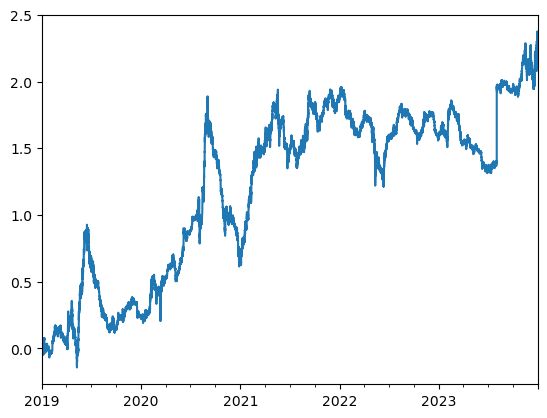

In [125]:
util.to_sharpe(shock_reversal(in_sample_ret,in_sample_close_prices, entry_z_score_threshold = -1, exit_zscore_threshold = 1, entry_lookback = 200, exit_lookback = 2000), in_sample_ret ,plot = True, purify = True)